In [310]:
import os
import numpy
import SimpleITK as sitk
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [311]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [312]:
path = 'data/interrsect_005.nii.gz'

reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
reader.SetFileName(path)
image = reader.Execute()

In [313]:
idxSlice = 24

# int labels to assign to the segmented white and gray matter.
labelWhiteMatter = 1
labelGrayMatter = 2

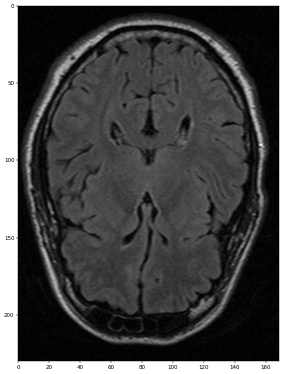

In [314]:
image_1 = image[:,:,idxSlice]

sitk_show(image_1)

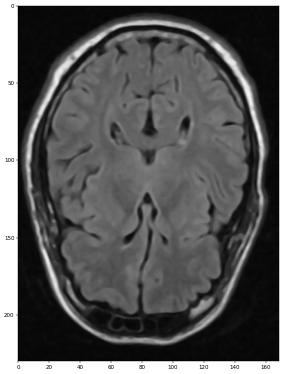

In [315]:
imgSmooth = SimpleITK.CurvatureFlow(image1=image_1,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

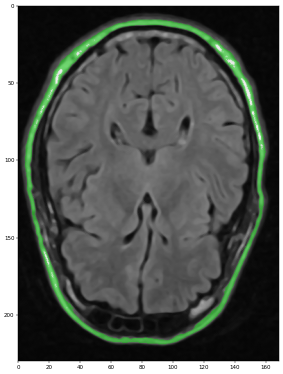

In [316]:
lstSeeds = [(120,44)]

img_skull_hightlighted = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=300, 
                                              upper=700,
                                              replaceValue=labelWhiteMatter)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSkullSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imgSkullSmoothInt, img_skull_hightlighted))

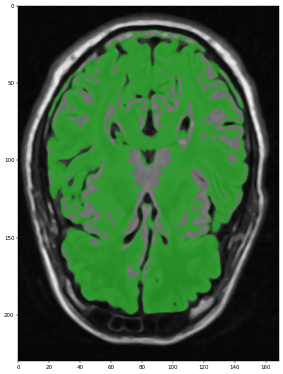

In [317]:
lstSeeds = [(180,70)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=210, 
                                              upper=330,
                                              replaceValue=labelWhiteMatter)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

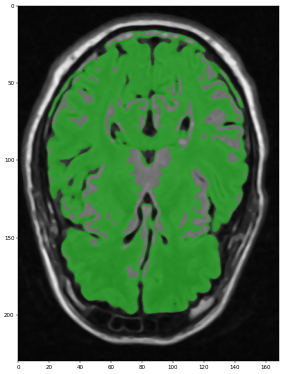

In [318]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

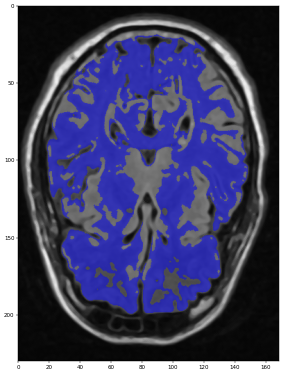

In [319]:
lstSeeds = [(235
             , 182)] #, (198, 80), (185, 102), (164, 43), (200,200), (180, 190)]

imgGrayMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=240, 
                                             upper=320,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

In [320]:
print(imgGrayMatter.GetSize())

(376, 512)


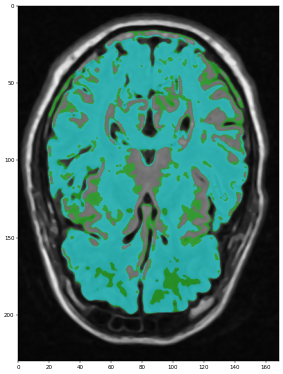

In [321]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

In [322]:


imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatterNoHoles/labelGrayMatter
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgGrayMatterNoHoles

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

RuntimeError: Exception thrown in SimpleITK Multiply: /Users/runner/work/1/sitk/Code/BasicFilters/src/sitkImageFilter.cxx:52:
sitk::ERROR: Input "image2" for "MultiplyImageFilter" has pixel type of "8-bit unsigned integer which does not match the primary input's pixel type of "64-bit float!
The "image2" input may need casting to the "64-bit float" pixel type.